### Preprocessing

#### Load Libraries and Dataset

In [21]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
%matplotlib inline

wbc = datasets.load_breast_cancer()
df_wbc = pd.DataFrame(wbc.data,columns=wbc.feature_names)
df_wbc['target'] = pd.Series(wbc.target)

X = df_wbc.drop(['target'], axis=1)
y = df_wbc['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

#### Build Model and Confusion Matrix

In [22]:
from sklearn.ensemble import RandomForestClassifier
## Edit Random Forest for Regression 


model = RandomForestClassifier(n_estimators=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [38]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]), fontsize=24,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    return(plt)

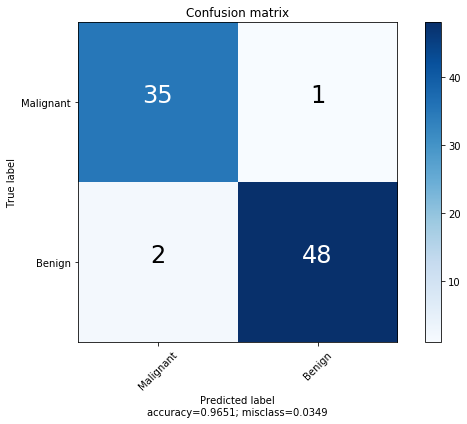

In [41]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
fig = plot_confusion_matrix(cm, ["Malignant", "Benign"], normalize=False)
fig.tight_layout()
fig.savefig("../Images/Confusion_Matrix.png", dpi=155)

In [28]:
fp = []
fn = []
y_test = list(y_test)
for item in range(len(y_test)):
    if (y_test[item] == 1) & (y_pred[item] == 0):
        fn.append(item)
    if (y_test[item] == 0) & (y_pred[item] == 1):
        fp.append(item)
    else:
        continue
print('Indicies of False Negatives are: ' + str(fn))
print('Indicies of False Positives are: ' + str(fp))

Indicies of False Negatives are: [10, 13]
Indicies of False Positives are: [73]


### Error Analysis

#### ELI5

In [53]:
from eli5 import show_prediction

## Show prediction of features in individual 
p = show_prediction(model, X_test.iloc[10], feature_names = X_train.columns.tolist(), show_feature_values=False)
p

#### Lime

In [76]:
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   feature_names=X_train.columns.values.tolist(),
                                                   class_names=y_train.unique())

predict_fn = lambda x: model.predict_proba(x).astype(float)
exp = explainer.explain_instance(X_test.iloc[10], predict_fn, num_features=3)
exp.show_in_notebook(show_all=False)

#### SHAP

In [82]:
import shap
example_1 = X_test.iloc[10]
explainer = shap.TreeExplainer(model, X_train)

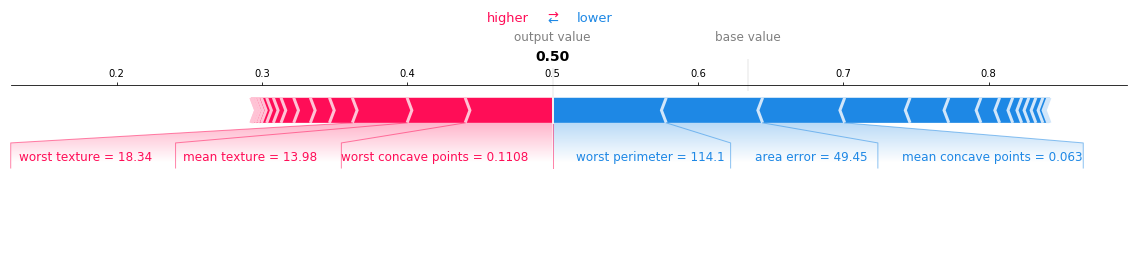

In [90]:
shap_values = explainer.shap_values(example_1)
#shap.initjs()
p = shap.force_plot(explainer.expected_value[1], shap_values[1], example_1,matplotlib=True,show=False)
plt.savefig("../Images/Shap_Values.png",dpi=150, bbox_inches='tight')

### Feature Selection

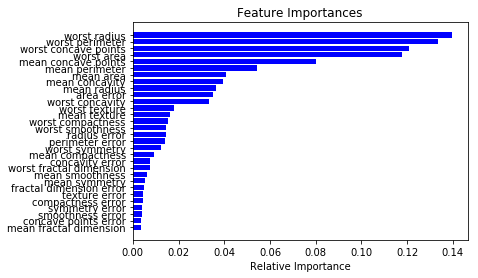

In [99]:
import numpy as np
features = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig("../Images/Feature_Importance.png", dpi=150,bbox_inches='tight')

#### ELI5

In [128]:
import eli5
from sklearn.preprocessing import MinMaxScaler
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(model).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist(), top=6)

#### Shap

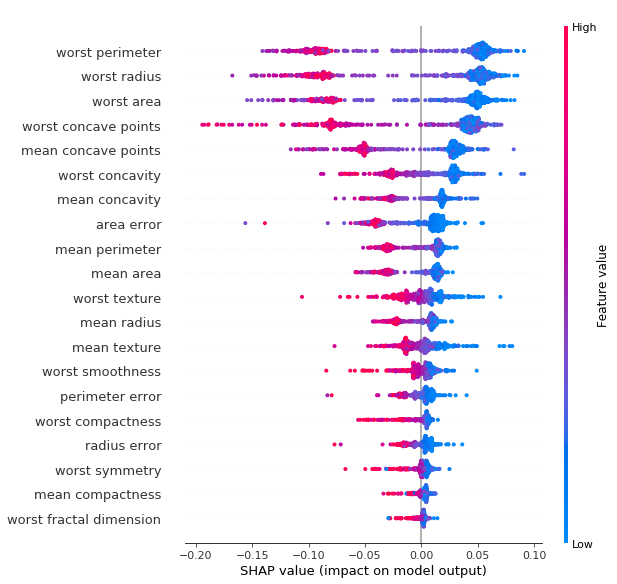

In [111]:
shap_values = explainer.shap_values(X_train)
p = shap.summary_plot(shap_values[1], X_train, show=False)
plt.savefig("../Images/Shap_features.png",dpi=150, bbox_inches='tight')

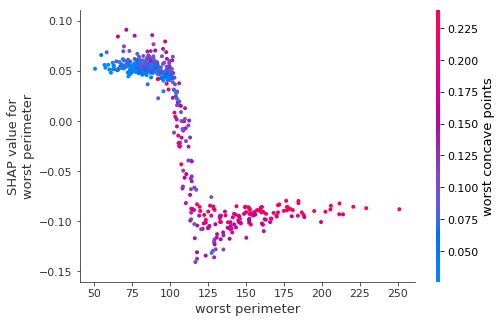

In [141]:
p = shap.dependence_plot('worst perimeter', shap_values[1], X_train, interaction_index='worst concave points')
p

#### PDP

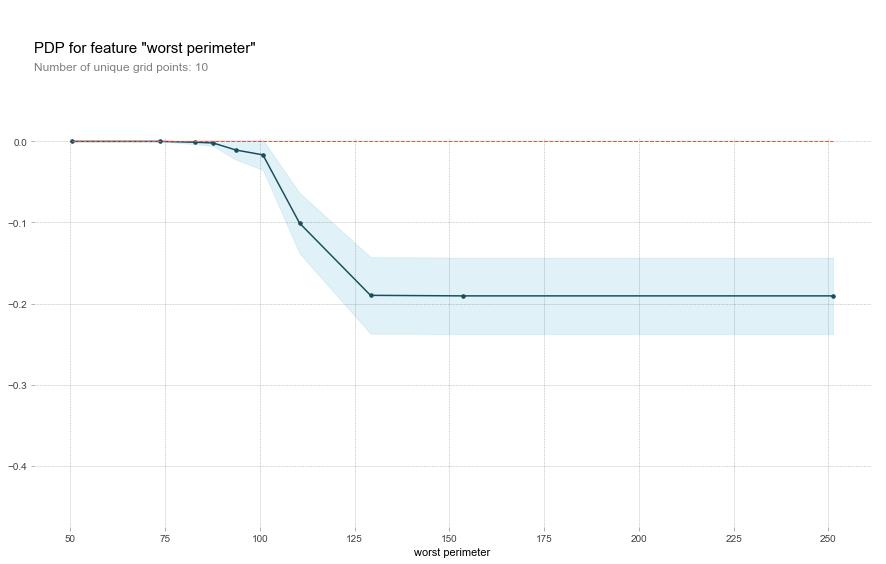

In [132]:
from matplotlib import pyplot as plt
%matplotlib inline
from pdpbox import pdp, get_dataset, info_plots

#pdp_width = pdp.pdp_isolate(model=model, dataset=X_train, model_features=X_train.columns.tolist(), feature='petal width (cm)')

pdp_width = pdp.pdp_isolate(model=model, dataset=X_train, model_features=X_train.columns.tolist(), feature='worst perimeter')

pdp.pdp_plot(pdp_width, 'worst perimeter')
#pdp.pdp_plot(pdp_width, 'petal width (cm)')
plt.savefig("../Images/PDP_perimeter.png", dpi=150, bbox_inches='tight')

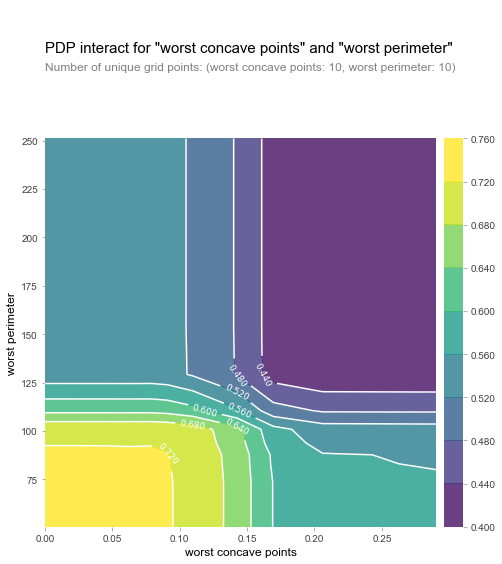

In [131]:
pdp_interaction = pdp.pdp_interact(model=model, dataset=X_train, model_features=X_train.columns.tolist(), features=['worst concave points', 'worst perimeter'])
pdp.pdp_interact_plot(pdp_interact_out=pdp_interaction, feature_names=['worst concave points', 'worst perimeter'], plot_type='contour')

plt.savefig("../Images/Concave_perimeter.png", dpi=150, bbox_inches='tight')

### End of Error Analysis and Feature Importances